In [1]:
### links used:
# for the whole setup:       https://huggingface.co/docs/transformers/tasks/semantic_segmentation#preprocess
# for criss cross attention: https://mmcv.readthedocs.io/en/latest/_modules/mmcv/ops/cc_attention.html
# segofrmer source code:     https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/segformer/modeling_segformer.py#L746

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [2]:
import torch
import numpy as np
from torch import nn
import json
import torchvision.transforms as T
from functools import reduce
from typing import Union
import math
import torch.nn.functional as F
import pickle
import os
import psutil

In [3]:
!pip install -q datasets transformers evaluate pynvml accelerate

In [4]:
from huggingface_hub import hf_hub_download
from pynvml import *
from datasets import load_dataset, load_from_disk
import evaluate
from transformers import SegformerFeatureExtractor
from transformers import TrainingArguments, Trainer, logging
from transformers import AutoModelForSemanticSegmentation
from transformers import SegformerForSemanticSegmentation, SegformerConfig

In [7]:
ds = load_dataset("scene_parse_150")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds=ds.sort('image')
ds=ds.shuffle(seed=42)

In [8]:
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}

label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [10]:
#train_ds=ds['train']#.train_test_split(test_size=0.996) #Using only a small portion of the dataset
#train_ds = train_ds['train']

validation_ds=ds['validation']#.train_test_split(test_size=0.996)
#validation_ds = validation_ds['train']

#test_ds=ds['test'].train_test_split(test_size=0.996)
#test_ds = test_ds['train']

In [ ]:
def remove_data(data, typee):
  #drop data missing annotations and mask
  data.set_format(type='pandas')
  if typee=='train':
    n=20210
  elif typee=='test':
    n=13#3352
  else:
    n=2000

  m=np.array
  indices=[]
  for i in range(n):
    if m(data[i]['image'][0]).shape[-1] != 3:
      indices.append(i)

  data.set_format(type='pytorch')

  if len(indices)==0:
    pass
  else:
    colored_indexes = list(range(len(data)))
    for i in indices:
      colored_indexes.remove(i)
    data=data.select(colored_indexes)

  return data

train_ds = remove_data(train_ds, 'train')
#validation_ds = remove_data(validation_ds, 'validation')
#test_ds = remove_data(test_ds, 'test')

In [ ]:
def train_transforms(example_batch):
  #qui possiamo randomizzare procedura di augmentation data
    transforms = T.RandomApply(
        [T.RandomHorizontalFlip(p=1),
         T.RandomInvert(),
         T.Grayscale(num_output_channels=3),
         T.GaussianBlur(9, sigma=0.1),
         T.RandomResizedCrop(512,scale=(0.5, 2.0)),
         T.RandomResizedCrop(1024,scale=(0.5, 2.0))
        ], p=0.25)
    
    feature_extractor=SegformerFeatureExtractor()

    images = [transforms(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    feature_extractor=SegformerFeatureExtractor()

    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [ ]:
train_ds.set_transform(train_transforms)

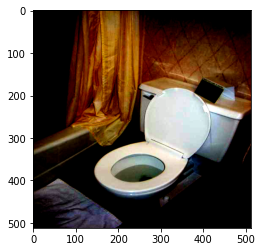

In [ ]:
#Look at augmentation
import matplotlib.pyplot as plt
img=torch.tensor(train_ds[7]['pixel_values'][:])
img=torch.permute(img, (1,2,0))
plt.imshow(img)

# Attention

In [11]:
def NEG_INF_DIAG(n: int, device: torch.device) -> torch.Tensor:
    """Returns a diagonal matrix of size [n, n].

    The diagonal are all "-inf". This is for avoiding calculating the
    overlapped element in the Criss-Cross twice.
    """
    return torch.diag(torch.tensor(float('-inf')).to(device).repeat(n), 0)


class Scale(nn.Module):
    """A learnable scale parameter.

    This layer scales the input by a learnable factor. It multiplies a
    learnable scale parameter of shape (1,) with input of any shape.

    Args:
        scale (float): Initial value of scale factor. Default: 1.0
    """

    def __init__(self, scale: float = 1.0):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(scale, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.scale


class CrissCrossAttention(nn.Module):
    """Criss-Cross Attention Module.

    .. note::
        Before v1.3.13, we use a CUDA op. Since v1.3.13, we switch
        to a pure PyTorch and equivalent implementation. For more
        details, please refer to https://github.com/open-mmlab/mmcv/pull/1201.

        Speed comparison for one forward pass

        - Input size: [2,512,97,97]
        - Device: 1 NVIDIA GeForce RTX 2080 Ti

        +-----------------------+---------------+------------+---------------+
        |                       |PyTorch version|CUDA version|Relative speed |
        +=======================+===============+============+===============+
        |with torch.no_grad()   |0.00554402 s   |0.0299619 s |5.4x           |
        +-----------------------+---------------+------------+---------------+
        |no with torch.no_grad()|0.00562803 s   |0.0301349 s |5.4x           |
        +-----------------------+---------------+------------+---------------+

    Args:
        in_channels (int): Channels of the input feature map.
    """

    def __init__(self, in_channels: int) -> None:
        super().__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = Scale(0.)
        self.in_channels = in_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """forward function of Criss-Cross Attention.

        Args:
            x (torch.Tensor): Input feature with the shape of
                (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output of the layer, with the shape of
            (batch_size, in_channels, height, width)
        """
        B, C, H, W = x.size()
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)
        energy_H = torch.einsum('bchw,bciw->bwhi', query, key) + NEG_INF_DIAG(
            H, query.device)
        energy_H = energy_H.transpose(1, 2)
        energy_W = torch.einsum('bchw,bchj->bhwj', query, key)
        attn = F.softmax(
            torch.cat([energy_H, energy_W], dim=-1), dim=-1)  # [B,H,W,(H+W)]
        out = torch.einsum('bciw,bhwi->bchw', value, attn[..., :H])
        out += torch.einsum('bchj,bhwj->bchw', value, attn[..., H:])

        out = self.gamma(out) + x
        out = out.contiguous()

        return out


    def __repr__(self) -> str:
        s = self.__class__.__name__
        s += f'(in_channels={self.in_channels})'
        return s

In [12]:
class MySegformerAttention(nn.Module):
    def __init__(self, config, hidden_size):
        super().__init__()
        self.cca = CrissCrossAttention(hidden_size)
        


    def forward(self, hidden_states, height, width, output_attentions=False):
       
        #self_outputs = self.self(hidden_states, height, width, output_attentions)
        #context_layer = self_outputs[0] # (1,16384,32) = (1,height*width,hidden_states.shape[-1] )

        x=torch.reshape(hidden_states, (hidden_states.shape[0],hidden_states.shape[-1], height, width))
        self_outputs= self.cca(x)
        self_outputs=torch.reshape(self_outputs, (hidden_states.shape[0], height*width, hidden_states.shape[-1]))
        self_outputs=(self_outputs,)


        #attention_output = self.output(self_outputs[0], hidden_states) # (1,16384,32)
        #outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        #print('outputs: ', (outputs[0].shape)) (1,16384,32)
       
        return self_outputs


## Layer substitution

In [ ]:
#RUN THIS CELL ONLY IF RUNNING FIRST EPOCH OF TRAINING, TO INITIALIZE THE MODEL,
#IF WANT TO LOAD MODEL FROM SAVED STATE USE NEXT CELL
pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(pretrained_model_name)
config=model.config


#aggiorneremo i pesi solo dei nuovi layer
for param in model.parameters(): 
    param.requires_grad = False


def replace_att_layers(model):
  #replace attention layers with our attention layer
  sizes=[32,32,64,64,160,160,256,256]
  counter=0

  for module in model.modules():
    classname = module.__class__.__name__

    if 'SegformerLayer' in classname:
      module.attention=MySegformerAttention(config, sizes[counter])
      counter+=1

  return model

model=replace_att_layers(model)

for param in model.decode_head.parameters():
  param.requires_grad = True


# Training

In [ ]:
metric = evaluate.load("mean_iou")

In [ ]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [ ]:
training_args = TrainingArguments(
    #auto_find_batch_size = True,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 4,
    evaluation_strategy = 'epoch',
    eval_accumulation_steps=1, # MAY CHANGE IT
    optim = 'adafactor',
    output_dir="/content/drive/MyDrive/AML/models/merda",
    learning_rate=6e-5,
    num_train_epochs=1,
    save_strategy="epoch",
    #eval_steps=1,
    remove_unused_columns=False,
    debug = 'underflow_overflow',
    prediction_loss_only = True, 
    log_level = 'critical',
    logging_strategy = 'epoch',
    #fp16_full_eval = True,
    #dataloader_num_workers = 2
    load_best_model_at_end = False
    #, gradient_checkpointing = True

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=validation_ds,
    compute_metrics=compute_metrics
)


In [ ]:
results = trainer.train() 
print_summary(results)

In [ ]:
import json
import seaborn as sns
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
sns.set_theme()
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams['figure.dpi'] = 92
!pip install natsort
from natsort import natsorted

Mounted at /content/drive


In [ ]:
dir_fd = os.open('/content/drive/MyDrive/AML/models/b0_very_final_train/', os.O_RDONLY)
dirs = os.listdir(dir_fd)
dirs = natsorted(dirs)
os.close(dir_fd)

In [ ]:
tr_loss = list()
val_loss = list()
for path in dirs:
  f = open('/content/drive/MyDrive/AML/models/b0_very_final_train/'+path+"/checkpoint-5051/trainer_state.json")
  data = json.load(f)
  tr_loss.append(data['log_history'][0]['loss'])
  val_loss.append(data['log_history'][1]['eval_loss'])

In [ ]:
loss = np.array((tr_loss, val_loss))
df = pd.DataFrame(data=loss.transpose(), index=dirs, columns=["Training", "Validation"])

In [ ]:
loss

array([[3.1511    , 2.7887    , 2.7248    , 2.6829    , 2.6511    ,
        2.6252    , 2.6033    , 2.6215    , 2.6016    , 2.5849    ,
        2.5701    , 2.5564    , 2.5438    , 2.5318    , 2.5109    ],
       [2.72740197, 2.63385344, 2.58298683, 2.54597092, 2.51767874,
        2.49482036, 2.47598076, 2.4855268 , 2.47253799, 2.46138144,
        2.45148349, 2.44230151, 2.43361044, 2.42541122, 2.42324018]])

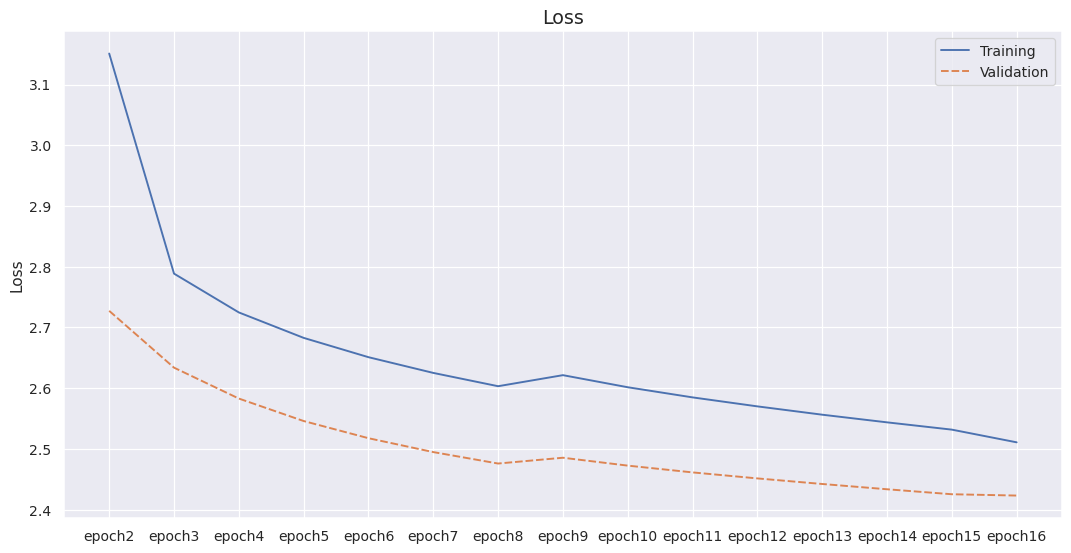

In [ ]:
plt.figure(figsize=(14,7))
sns.lineplot(data=df)
ax = plt.gca()
ax.set_ylabel("Loss",fontsize=12)
ax.set_title("Loss", fontsize=15)
plt.savefig("/content/drive/MyDrive/AML/loss.pdf")
plt.show()